# Dogs v.s. Cats

_por David F. Mora_. 2021. Para mas información consultar  _Deep learning with Python_ por Francois Chollet.

_Nota: Para correr el notebook en un tiempo razonable es necesario usar GPU en runtime_.

Problema de clasificación de imagenes de perros y gatos extraido de Kaggle.

In [3]:
import tensorflow as tf
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from keras.applications import vgg16


El dataset original tiene 25000 imagenes(12500 de cada animal), sin embargo para este ejercicio se tomaran 1000 de cada uno para elentrenamiento y 500 de cada uno para validación y testeo

In [ ]:
def make_dir(root, name):
    path = os.path.join(root , f'{name}') 
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    return path

# make the necessary directories
root = '/content/'
train_dir = make_dir(root, 'training')
test_dir = make_dir(root, 'test')
val_dir = make_dir(root, 'validation')

train_dogs_dir = make_dir(train_dir, 'dogs')
train_cats_dir = make_dir(train_dir, 'cats')
test_dogs_dir = make_dir(test_dir, 'dogs')
test_cats_dir = make_dir(test_dir, 'cats')
val_dogs_dir = make_dir(val_dir, 'dogs')
val_cats_dir = make_dir(val_dir, 'cats')

Una vez descargados los datos, los organizamos en directorios divididos en _training_, _validation_ y _test_.


In [ ]:
uncompresed = '/content/train'


def copy(from_dir, to_dir, imgs):
    for img in imgs:
        src = os.path.join(from_dir, img)
        dst = os.path.join(to_dir, img)
        shutil.copyfile(src, dst)
    
dogs = ['dog.{}.jpg'.format(i) for i in range(1000)]
cats = ['cat.{}.jpg'.format(i) for i in range(1000)]

copy(uncompresed, train_dogs_dir, dogs)
copy(uncompresed, train_cats_dir, cats)

dogs = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
cats = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]

copy(uncompresed, val_dogs_dir, dogs)
copy(uncompresed, val_cats_dir, cats)

dogs = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
cats = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]

copy(uncompresed, test_dogs_dir, dogs)
copy(uncompresed, test_cats_dir, cats)


# Construción del modelo

El modelo se divide en dos partes, la primera es la fase de _feature extraction_, que se compone de capas de convoluciones y maxpooling. Poseteiormente sigue la fase de _lineal classifier_, la cual es una secuencia de capaz densas que se encargan de clasificar las caracteristicas extraidas en la anterior base.

In [2]:
model = models.Sequential()
# red de capas de convolución y max pooling
model.add(layers.Conv2D(32, (3, 3),
                        activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Rescaling(1./225))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
# aplana a tensor a vector
model.add(layers.Flatten())
# red densa
model.add(layers.Dense(512, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])


2022-08-12 19:25:05.747074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 19:25:05.747101: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-12 19:25:21.740180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-12 19:25:21.747064: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 19:25:21.759591: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (david-80uv): /proc/driver/nvidia/version does not exist
2022-08-12 19:25:21.858246: I tensorflow/core/platform/cpu_feature

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
rescaling (Rescaling)        (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

# Preprocesamiento del input

Para el procesamiento de nuestro input, el cual esta organizado en carpetas, utilizamos los _datasets_ de Tensorflow, con el cual podremos extraer las clases directorios y generar batches de _imgs, labels_ de forma automatica.

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=(150, 150),
    batch_size=32)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Entrenamiento

72% de _accuracy_ en validación en el modelo construido desde cero y entrenado con 2000 datos.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks
                    )


Epoch 1/30
63/63 [==============================] - 38s 96ms/step - loss: 0.7798 - accuracy: 0.5060 - val_loss: 0.6913 - val_accuracy: 0.5040
Epoch 2/30
63/63 [==============================] - 6s 89ms/step - loss: 0.7008 - accuracy: 0.5395 - val_loss: 0.8096 - val_accuracy: 0.5030
Epoch 3/30
63/63 [==============================] - 6s 90ms/step - loss: 0.6670 - accuracy: 0.6035 - val_loss: 0.6397 - val_accuracy: 0.6540
Epoch 4/30
63/63 [==============================] - 6s 88ms/step - loss: 0.6304 - accuracy: 0.6720 - val_loss: 0.7295 - val_accuracy: 0.6200
Epoch 5/30
63/63 [==============================] - 6s 86ms/step - loss: 0.5781 - accuracy: 0.7095 - val_loss: 0.5856 - val_accuracy: 0.6920
Epoch 6/30
63/63 [==============================] - 6s 86ms/step - loss: 0.5541 - accuracy: 0.7320 - val_loss: 0.5792 - val_accuracy: 0.6760
Epoch 7/30
63/63 [==============================] - 6s 89ms/step - loss: 0.4947 - accuracy: 0.7700 - val_loss: 0.5584 - val_accuracy: 0.7270
Epoch 8/30
6

## Grafica de los resultados

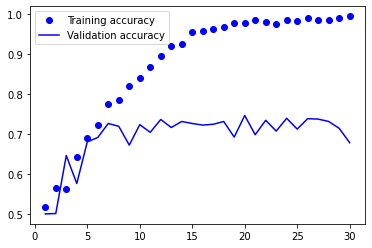

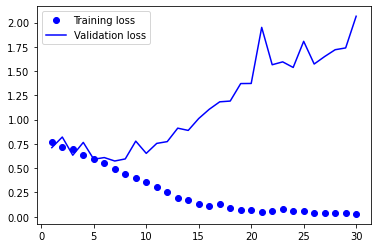

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, 31)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()


In [ ]:
model.evaluate(test_ds)

32/32 [==============================] - 30s 43ms/step - loss: 0.7018 - accuracy: 0.5000


[0.7017582058906555, 0.5]

# Data augmentation (aumento de datos)

A travez del _Data augmentation_ podemos crear nuevas imagenes a partir de realizar simples transformaciones a las imagenes actuales. Esto es muy util para mitigar el _overfiting_ ya que el modelo no va a "ver" la misma imagen 2 veces y entre mas datos, mejor va a ser la capacidad del modelo de generalizar patrones.

In [ ]:
augmentation = models.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2)
     ]
)


Ejemplo de las transformaciones

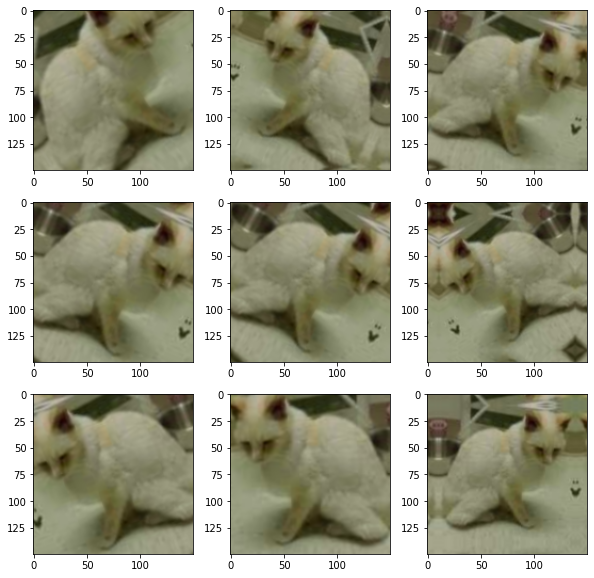

In [ ]:
plt.figure(figsize=(10, 10))

for imgs, _ in train_ds.take(1):
    for i in range(9):
        aug = augmentation(imgs)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug[0].numpy().astype('uint8'))


## Construción del modelo

In [ ]:
model = models.Sequential()
model.add(layers.Rescaling(1./225))
model.add(augmentation)
# red de capas de convolución y max pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
# aplana a tensor a vector
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
# red densa 
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics = ['accuracy'])

## Entrenamiento

In [ ]:
history = model.fit(
    train_ds,
    epochs=70,
    validation_data = val_ds
)

Epoch 1/70
63/63 [==============================] - 10s 91ms/step - loss: 0.7006 - accuracy: 0.5110 - val_loss: 0.6911 - val_accuracy: 0.5810
Epoch 2/70
63/63 [==============================] - 6s 84ms/step - loss: 0.6925 - accuracy: 0.5605 - val_loss: 0.7017 - val_accuracy: 0.5140
Epoch 3/70
63/63 [==============================] - 6s 84ms/step - loss: 0.6718 - accuracy: 0.6210 - val_loss: 0.6243 - val_accuracy: 0.6490
Epoch 4/70
63/63 [==============================] - 6s 85ms/step - loss: 0.6341 - accuracy: 0.6510 - val_loss: 0.6127 - val_accuracy: 0.6430
Epoch 5/70
63/63 [==============================] - 6s 84ms/step - loss: 0.6219 - accuracy: 0.6480 - val_loss: 0.6401 - val_accuracy: 0.6100
Epoch 6/70
63/63 [==============================] - 5s 83ms/step - loss: 0.6135 - accuracy: 0.6860 - val_loss: 0.6069 - val_accuracy: 0.6730
Epoch 7/70
63/63 [==============================] - 6s 84ms/step - loss: 0.5883 - accuracy: 0.6815 - val_loss: 0.5792 - val_accuracy: 0.6970
Epoch 8/70
6

## Grafica de los resultados

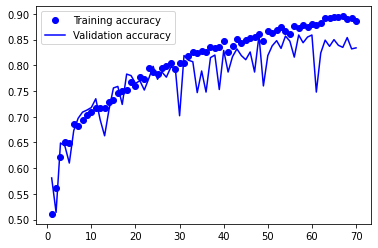

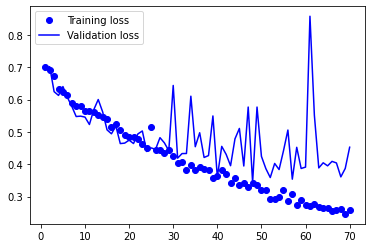

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc,'b', label = 'Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label = 'Validation loss')
plt.legend()

plt.show()

## Evaluación

Mejora de aproximadamente 12% en accuracy con respecto al modelo sin _data augmentation_.

In [ ]:
model.evaluate(test_ds)

32/32 [==============================] - 2s 38ms/step - loss: 0.5138 - accuracy: 0.8230


[0.5137819647789001, 0.8230000138282776]

# Modelos pre-entrenados


Para mejorar el rendimiento de nuestros modelos con una pequeña cantidad de datos, es buena idea "apoyarnos" en modelos pre-entrenados en  classificación de imagenes entrenados en datasets grandes y generales. Aún cuando las classes de los problemas de cada modelo sean distintas, el modelo pre-entrenado ha obtenido la capacidad de "abstraer" las caracteristicas generales del mundo visual que son utiles para cualquier modelo de clasificación de imagenes.

No obstante, solo resulta util reutilizar la fase de _feature extraction_, tambien llamada _conv_base_, especificamente las primeras capas de la misma.

Se usara el modelo VGG16, el cual tiene una arquitectura similar a la que ya se ha mostrado.

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Feature extraction

### Primer metodo

Nuestra primera alternativa para usar modelos pre-entrenados, y la mas economica computacionalmente, consiste en pasar nuestros inputs por la _conv_base_ y sus outputs como nuevos inputs para un clasificador lineal aparte. La desventaja es que como los datos pasan una sola vez por la _conv_base_ no es posible usar _data_augmentation.





In [ ]:
def get_features_and_labels(dataset):
    features = []
    labels = []
    for img_batch, labels_batch in dataset:
        # preprocesamiento para VGG16
        preprocessed = vgg16.preprocess_input(img_batch)
        prediction_features = conv_base(preprocessed)  # outputs
        features.append(prediction_features)
        labels.append(labels_batch)
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = get_features_and_labels(train_ds)
validation_features, validation_labels = get_features_and_labels(val_ds)
test_features, test_labels = get_features_and_labels(test_ds)


In [ ]:
# Este es el clasificador lineal que es completamente aparte del conv_base
model = models.Sequential([
                           layers.Flatten(),
                           layers.Dense(512, activation='relu'),
                           layers.Dropout(0.5),
                           layers.Dense(1, activation='sigmoid')])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(train_features, train_labels,
          batch_size=20, epochs=30,
          validation_data=(validation_features, validation_labels))


Epoch 1/30
100/100 [==============================] - 1s 9ms/step - loss: 6.3459 - acc: 0.9090 - val_loss: 0.9918 - val_acc: 0.9670
Epoch 2/30
100/100 [==============================] - 1s 8ms/step - loss: 1.1617 - acc: 0.9650 - val_loss: 1.5942 - val_acc: 0.9610
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.6892 - acc: 0.9795 - val_loss: 1.8402 - val_acc: 0.9650
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.7039 - acc: 0.9770 - val_loss: 1.3297 - val_acc: 0.9700
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5499 - acc: 0.9830 - val_loss: 1.9386 - val_acc: 0.9600
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.5334 - acc: 0.9870 - val_loss: 2.0162 - val_acc: 0.9610
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3650 - acc: 0.9890 - val_loss: 1.4098 - val_acc: 0.9690
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

Accuracy de 95%.

In [ ]:
model.evaluate(test_features, test_labels)

32/32 [==============================] - 0s 4ms/step - loss: 2.9753 - acc: 0.9590


[2.9753153324127197, 0.9589999914169312]

### Segundo metodo


Para la segundo metodo se opta por añadir un clasificador lineal encima de la base convolucional(_conv_base_) y entrenar en todo el modelo congelando los parametros de la _conv_base_ pero usando _data augmentation_ de forma que el modelo no va a ver la misma imagen dos veces y asi mitigamos el _overfiting_.

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False # congelamiento de los parametros

In [ ]:
input = keras.Input(shape=(150, 150, 3))
x = augmentation(input) 
x = vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(input,output)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
63/63 [==============================] - 16s 220ms/step - loss: 6.2797 - acc: 0.8820 - val_loss: 7.0854 - val_acc: 0.8770
Epoch 2/50
63/63 [==============================] - 14s 215ms/step - loss: 2.0679 - acc: 0.9265 - val_loss: 0.9976 - val_acc: 0.9640
Epoch 3/50
63/63 [==============================] - 14s 217ms/step - loss: 1.1865 - acc: 0.9375 - val_loss: 0.6144 - val_acc: 0.9680
Epoch 4/50
63/63 [==============================] - 14s 216ms/step - loss: 0.7951 - acc: 0.9490 - val_loss: 0.5766 - val_acc: 0.9760
Epoch 5/50
63/63 [==============================] - 14s 217ms/step - loss: 0.7197 - acc: 0.9435 - val_loss: 0.5575 - val_acc: 0.9660
Epoch 6/50
63/63 [==============================] - 14s 216ms/step - loss: 0.5201 - acc: 0.9575 - val_loss: 0.6077 - val_acc: 0.9660
Epoch 7/50
63/63 [==============================] - 14s 215ms/step - loss: 0.6161 - acc: 0.9555 - val_loss: 0.6624 - val_acc: 0.9590
Epoch 8/50
63/63 [==============================] - 14s 215ms/step - 

### Grafica de los resultados

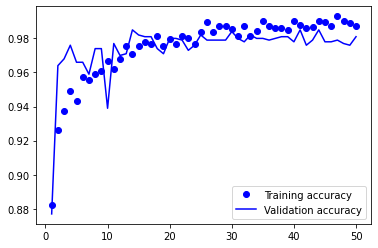

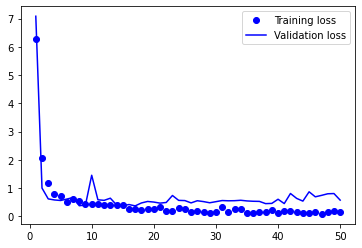

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc,'b', label = 'Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label = 'Validation loss')
plt.legend()

plt.show()

El segundo metodo tiene un accuracy de 96% aproximadamente, lo cual es 1% mejor que el primer metodo.

In [ ]:
model.evaluate(test_ds)

32/32 [==============================] - 5s 137ms/step - loss: 0.9356 - acc: 0.9640


[0.9355567097663879, 0.9639999866485596]

## Fine tuning


Ahora lo que se hara es congelar las capas del _conv_base_ exceptuando las 4 de mas arriba, ya que esta son menos generales y por lo tanto entrenarlas para nuestro problema puede producir mejores resultados. Solo se descogelan las ultimas 4 ya que, las capas anteriores "captan" patrones mas generales y entrenarlas con nuestro problema anularia esa capacidad ya que como nuestro clasificador lineal comienza con parametros aleatorios, generaria ajustes muy bruscos que estropearian los parametros pre-entrenados.

Cabe destacar que el clasificador lineal fue entrenado previamente con los parametros del _conv_base_ congelados. Para intentar "contener" los ajustes que se hagan a los parametros del _conv_base_, asi mismo, se usa un paso de aprendizaje(_learning rate_) mas pequeño por la misma razon.

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
63/63 [==============================] - 14s 213ms/step - loss: 0.0965 - acc: 0.9930 - val_loss: 0.5521 - val_acc: 0.9820
Epoch 2/30
63/63 [==============================] - 14s 214ms/step - loss: 0.1045 - acc: 0.9910 - val_loss: 0.6004 - val_acc: 0.9810
Epoch 3/30
63/63 [==============================] - 14s 214ms/step - loss: 0.1210 - acc: 0.9910 - val_loss: 0.7688 - val_acc: 0.9800
Epoch 4/30
63/63 [==============================] - 14s 215ms/step - loss: 0.0892 - acc: 0.9940 - val_loss: 0.7548 - val_acc: 0.9740
Epoch 5/30
63/63 [==============================] - 14s 216ms/step - loss: 0.1519 - acc: 0.9915 - val_loss: 0.5608 - val_acc: 0.9780
Epoch 6/30
63/63 [==============================] - 14s 216ms/step - loss: 0.1134 - acc: 0.9915 - val_loss: 0.6095 - val_acc: 0.9790
Epoch 7/30
63/63 [==============================] - 14s 215ms/step - loss: 0.1261 - acc: 0.9870 - val_loss: 0.6246 - val_acc: 0.9760
Epoch 8/30
63/63 [==============================] - 14s 215ms/step - 

Finalmente, obtenemos unas precision de 97% aproximadamente, lo cual es equivalente a los mejores modelos del momento en que se lanzo este problema en Kaggle.

In [ ]:
model.evaluate(test_ds)

32/32 [==============================] - 5s 134ms/step - loss: 0.8349 - acc: 0.9700


[0.8349345326423645, 0.9700000286102295]

# Convolution Visualization

## Layer activation


In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [ ]:
layer_name = "block1_conv1"
layer = conv_base.get_layer(layer_name)



# Filter visualization


In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
layer_name = "block1_conv2"
layer = conv_base.get_layer(name=layer_name)
model = keras.Model(conv_base.input, layer.output)


def compute_loss(img, filter):
    activation = model(img)
    loss = tf.reduce_mean(activation[:,:,:,filter])
    return loss

@tf.function
def gradient_ascent_step(img, filter, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter)
    grad = tape.gradient(loss, img)
    grad = tf.math.l2_normalize(grad)
    img += learning_rate * grad
    return img

In [ ]:
img_width = 150
img_height = 150

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()


def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

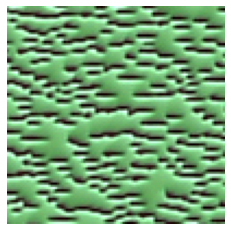

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=6)))